In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using BenchmarkTools
using Statistics
using AdaptiveTransportMap
using JLD
using Test
using Plots
using LaTeXStrings

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [3]:
# Define parameters
Ne = 100
Nx = 40
Ny = 20
Δtdyn = 0.05
Δtobs = 0.1

σx = 1e-2
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)
t0 = 0.0
tf = 600.0
Tf = ceil(Int64, tf/Δtobs)

m0 = zeros(Nx)
C0 = Matrix(1.0*I, Nx, Nx)

f = lorenz96!
h(t,x) = x[1:2:Nx]

model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, m0, C0, 0, 0, 0, f, h);

In [4]:
# Set initial condition
x0 = model.m0 + sqrt(model.C0)*randn(Nx)

# Run dynamics and generate data
data = generate_lorenz96(model, x0, Tf);

In [5]:
# Set initial condition
X = zeros(model.Ny + model.Nx, Ne)
X[model.Ny+1:model.Ny+model.Nx,:] .= sqrt(model.C0)*randn(model.Nx, Ne) .+ model.m0

t0 = 0.0
dyn = DynamicalSystem(model.f, model.h)
enkf = StochEnKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, false, false)

Stochastic EnKF  with filtered = false


In [6]:
statehist = seqassim(dyn, data, Tf, model.ϵx, enkf, X, model.Ny, model.Nx, t0);

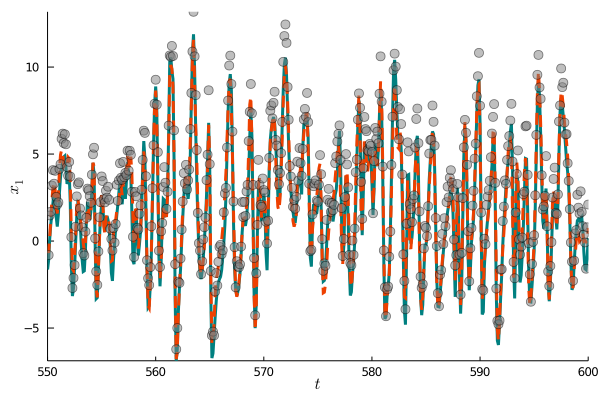

In [7]:
# Plot the first component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1", legend = false)
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal)
plot!(plt, data.tt[nb:Δ:ne], mean_hist(statehist)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, markersize = 3)
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5)
plt

### Benchmark of the EnKF filter

In [8]:
path = "/media/mat/HDD/AdaptiveTransportMap/src/lorenz96/data/"
Nx = 40
Ny = 20
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz96(path, Ne_array);

Ne 10 RMSE: 5.021582966502929
Ne 20 RMSE: 4.736719714821984
Ne 40 RMSE: 3.5717673341081655
Ne 60 RMSE: 1.8052661404917711
Ne 100 RMSE: 0.4915123041881811
Ne 200 RMSE: 0.45638494462123597
 35.236290 seconds (70.71 M allocations: 15.053 GiB, 10.38% gc time)


In [9]:
metric_list = benchmark_lorenz96(model, data, path, [200], [1.01])

(Ne, β) = (200, 1.01)
 30.216348 seconds (63.60 M allocations: 13.674 GiB, 10.72% gc time)
Ne = 200
Ne 200& β 1.01 RMSE: 0.4707619250224883


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.39268012178970635, 0.37909120835370663, 0.4141883358725064, 0.4042092343881028, 0.2654591892902855, 0.30203663584046897, 0.294293367677839, 0.31360008727894984, 0.33131225310382245, 0.2713353609798564  …  0.43380987640770596, 0.5003899667788113, 0.7283997410697859, 0.7297407746094586, 0.6988541244683363, 0.6746549689407546, 0.6465878228249552, 0.7275701253192048, 0.6341794884570855, 0.5503327732147265], 0.4411889582600375, 0.4707619250224883, 0.16965749778122646, [0.8206458048160489, 0.7350138822509159, 0.7023113132371095, 0.6885271971495807, 0.6408894860816274, 0.6810835290091994, 0.5795676006080293, 0.5967796287610299, 0.5632078982829745, 0.5074057879455569  …  0.7616015657067902, 0.7153774735701679, 0.8464600477096653, 0.9747972702110206, 0.9742573577356864, 0.9949136699679598, 0.883781592134237, 0.8143226506377003, 0.7869799304444735, 0.757775810167662], 0.730245403651608, 0.7408542175334756, 0.12876597609366464, [1.0, 1.0, 1.0, 1.0,